# Topology of time series

針對時間序列的拓樸分析有time-delay embedding，或是稱**Takens embedding**，該方法為Floris Taken在研究動力系統研究時所使用的，為了更好理解，直接上範例講解。

1. 首先假設時間序列的公式$x(t)=sin(t)+sin(2t)$，其中t為時間，而目標是要從該時間序列重新建構他的動態架構
2. 再來選擇參數，其中有兩個參數分別是嵌入$m$和時間延遲$T$，為了方便視覺化，這裡的m為3也就是會立體呈現該資料點重新建構後的圖，而時間延遲為1秒
3. 每個向量由原始時間序列的一個數據點以及其隨後的m-1個延遲數據點組成。所以說對於延遲1秒的向量可以表示為: $V(t)=[x(t),x(t+T),x(t+2T)]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud

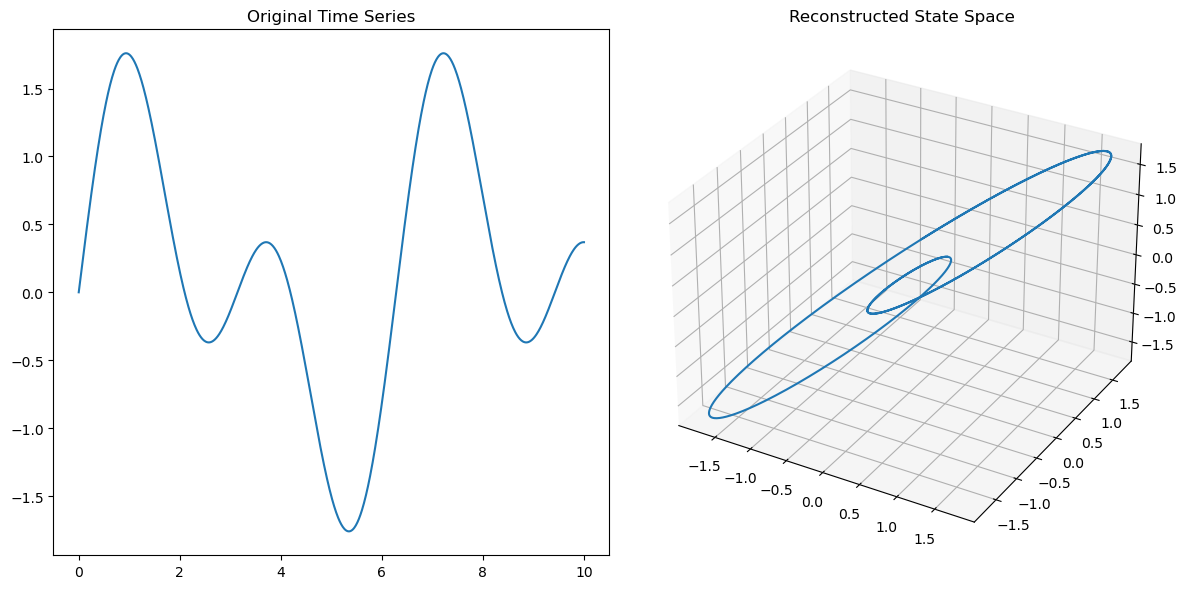

In [2]:
# 時間序列數據
t = np.linspace(0, 10, 1000)
x = np.sin(t) + np.sin(2*t)

# 嵌入維度和時間延遲
m = 3 
tau = 10

# 構建時間延遲向量
V = np.array([x[:-2*tau], x[tau:-tau], x[2*tau:]])

# 原始數據
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(t, x)
plt.title('Original Time Series')

# 重構後
plt.subplot(122, projection='3d')
plt.plot(V[0], V[1], V[2])
plt.title('Reconstructed State Space')
plt.tight_layout()
plt.show()

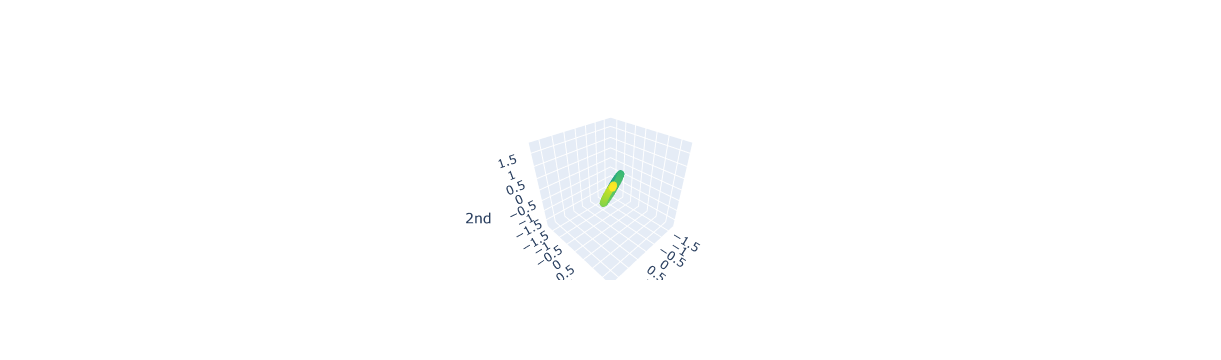

In [19]:
embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type = "fixed",
    n_jobs = 2,
    time_delay = 16,
    dimension = 3,
    stride = 3,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)
plot_point_cloud(y_nonperiodic_embedded)

In [20]:
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

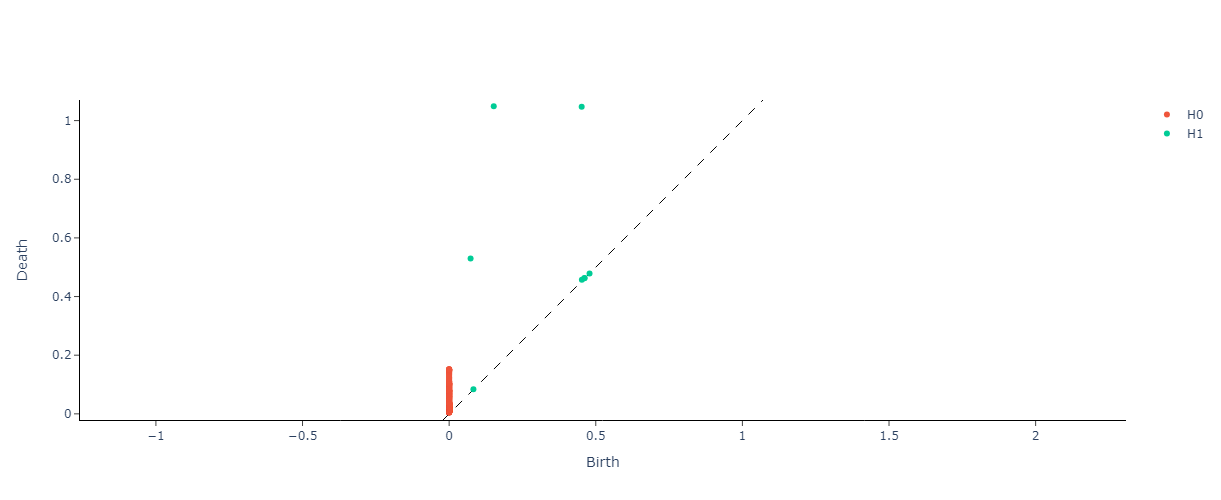

In [23]:
from gtda.homology import VietorisRipsPersistence

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions = [0, 1, 2], n_jobs = 6
)
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded);

# 有週期性的資料
當你獲取一筆時間序列的資料，不太可能在多維空間、不處理資料的情況下獲取漂亮的hole，而當這筆資料有週期性的時候，當我們使用Taken embedding的方式處理，可獲取一個漂亮的圓。而觀察這個hole，或是loop的方式可以使用persistent homology裡面的rips diagram來操作，其中filtration的方式也可以考慮其他的。

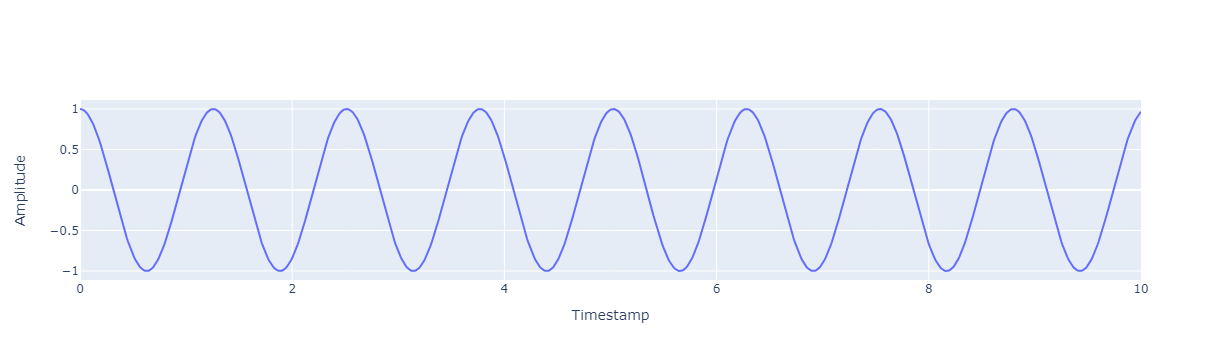

In [27]:
x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.cos(5 * x_periodic)

fig = go.Figure(data=go.Scatter(x=x_periodic, y=y_periodic))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

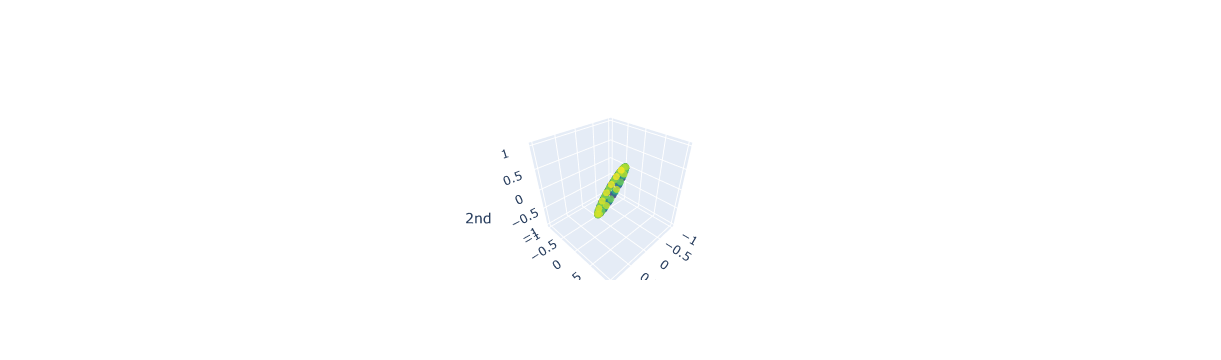

In [28]:
embedding_dimension_periodic = 6
embedding_time_delay_periodic = 8
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)

plot_point_cloud(y_periodic_embedded)

# PCA

當我們使用PCA的時候，在這個範例中我們將6維的資料降到3維來視覺化，而圖中我們可以觀察到一些距離集中在一起的hole很遠的幾個點雲，當我們將這筆資料放進diagram，將會得出該資料點的離群。

其中我想補充一下，比起使用PCA，[這篇](http://bertrand.michel.perso.math.cnrs.fr/Enseignements/TDA/Mapper.html)介紹mapper algo的文章介紹到期時PCA在某些情況下不是特別好用，比如說PCA無法在Torus這種資料形態下找出hole，這是由於PCA主要不是找出拓樸結構，因為他是在計算變異，而從正上方投影又不是最小的變異，所以除非特別去調整，不然不會默認地找出他的hole。

In [35]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)

y_periodic_embedded.shape

(96, 6)

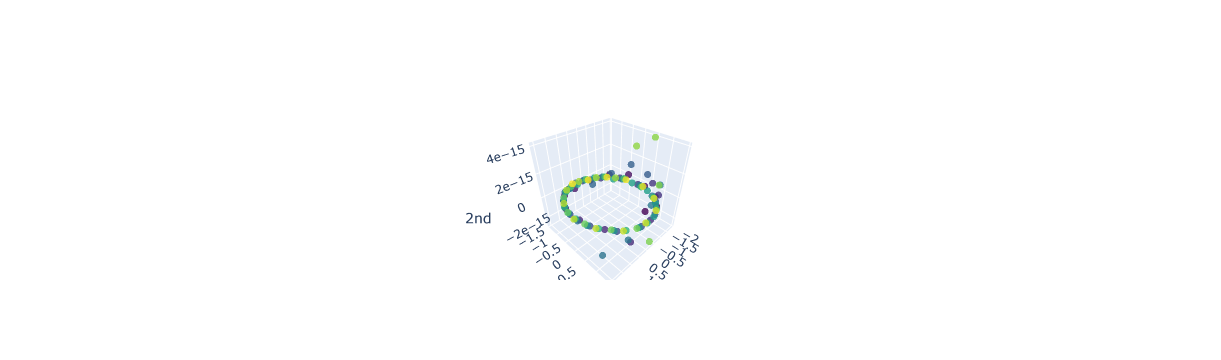

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Persistence diagram for periodic signal


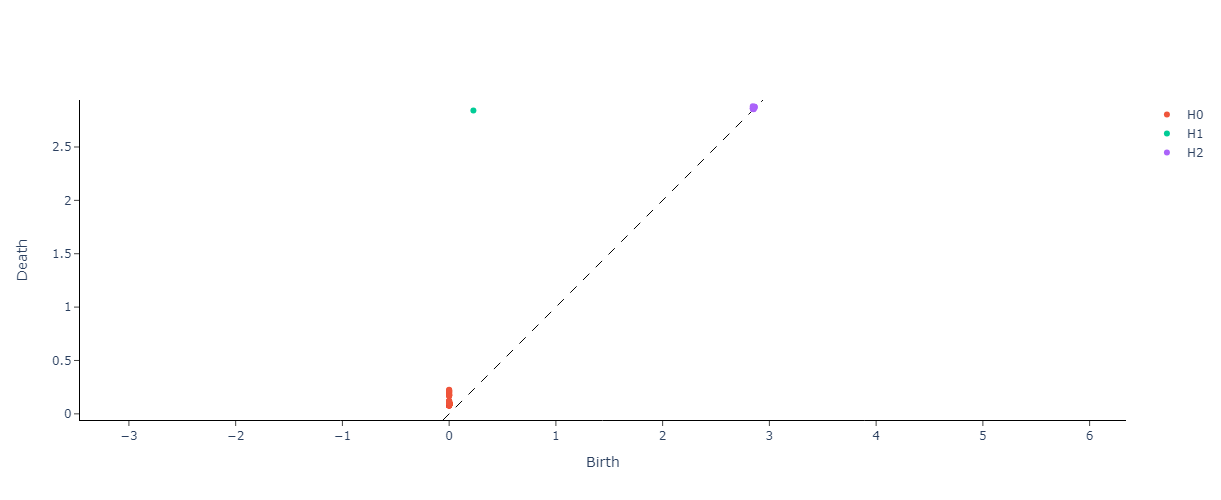

array([[[0.        , 0.07870309, 0.        ],
        [0.        , 0.07874865, 0.        ],
        [0.        , 0.07876879, 0.        ],
        [0.        , 0.0789723 , 0.        ],
        [0.        , 0.07901768, 0.        ],
        [0.        , 0.07924133, 0.        ],
        [0.        , 0.07937539, 0.        ],
        [0.        , 0.07968466, 0.        ],
        [0.        , 0.07976791, 0.        ],
        [0.        , 0.08014491, 0.        ],
        [0.        , 0.08035405, 0.        ],
        [0.        , 0.08092587, 0.        ],
        [0.        , 0.08117823, 0.        ],
        [0.        , 0.08171511, 0.        ],
        [0.        , 0.08185182, 0.        ],
        [0.        , 0.0824421 , 0.        ],
        [0.        , 0.08275363, 0.        ],
        [0.        , 0.08340199, 0.        ],
        [0.        , 0.08356439, 0.        ],
        [0.        , 0.08461369, 0.        ],
        [0.        , 0.08478926, 0.        ],
        [0.        , 0.0855306 , 0

In [32]:
from gtda.homology import VietorisRipsPersistence

y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
y_periodic_embedded = y_periodic_embedded[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for periodic signal")
periodic_persistence.fit_transform_plot(y_periodic_embedded)

# 實際應用
在上述介紹到的資料中拿類似波長的圖形來轉換，其實當我們把y軸進行轉換的話就可以對其進行實際分析，例如[這篇論文](https://etd.ohiolink.edu/acprod/odb_etd/etd/r/1501/10?clear=10&p10_accession_num=osu155563664988436)的目的是比較不同周期內車輛流量的改變，以及尋找非假日和假日間交通流量差，而他的y軸就是交通量。

這篇論文所使用的方法我用以下的步驟來總結: 首先透過Time-Delay Embedding來將週期資料進行結構變換，並且提到ParfreeDelutter Algorithm以及Declutter Algorithm的去雜音方法，再來使用PCA映射到低維空間更好視覺化或分析，Persistent Homology中的Diagrams來視覺化查看他們的loop拓樸特徵，計算不同持久圖的Bottleneck Distance後進行Clustering。